In [1]:
#%matplotlib inline
%matplotlib widget

In [2]:
isdark = True

In [3]:
# initialization
from rayoptics.environment import *

from rayoptics.gui import dashboards

from matplotlib import gridspec
from matplotlib.colors import LogNorm, PowerNorm, Normalize
from mpl_toolkits.mplot3d import axes3d

#import colorcet as cc

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

In [4]:
root_pth = Path(rayoptics.__file__).resolve().parent

# Create a new model

In [19]:
opm = OpticalModel()
sm = opm['seq_model']
osp = opm['optical_spec']
pm = opm['parax_model']
em = opm['ele_model']
pt = opm['part_tree']
ss = opm['specsheet']
ar = opm['analysis_results']

## Define first order aperture and field for system

In [20]:
pupil_diameter = 100.
pupil_radius = pupil_diameter/2
osp.pupil = PupilSpec(osp, key=['object', 'pupil'], value=pupil_diameter)

# single field on-axis
osp.field_of_view = FieldSpec(osp, key=['object', 'angle'], flds=[0.0])

# wavelength for analysis: 550nm
osp.spectral_region = WvlSpec([('e', 1.0)], ref_wl=0)

### object at infinity, i.e. collimated input

In [21]:
sm.gaps[0].thi = 1e+11

In [22]:
opm.add_mirror(lbl='M1', profile=Conic, r=-500., cc=-1., t=-250.)

In [23]:
sm.list_model()

              c            t        medium     mode   zdr      sd
  Obj:     0.000000  1.00000e+11       air             1      0.0000
   M1:    -0.002000     -250.000       air    reflect -1      50.000
  Img:    -0.000000      0.00000                      -1  1.2880e-07


In [24]:
opm.update_model()
sm.list_model()
fod = ar['parax_data'].fod

              c            t        medium     mode   zdr      sd
  Obj:     0.000000  1.00000e+11       air             1      0.0000
   M1:    -0.002000     -250.000       air    reflect -1      50.000
  Img:    -0.000000      0.00000                      -1  1.2880e-07


# Draw a lens picture

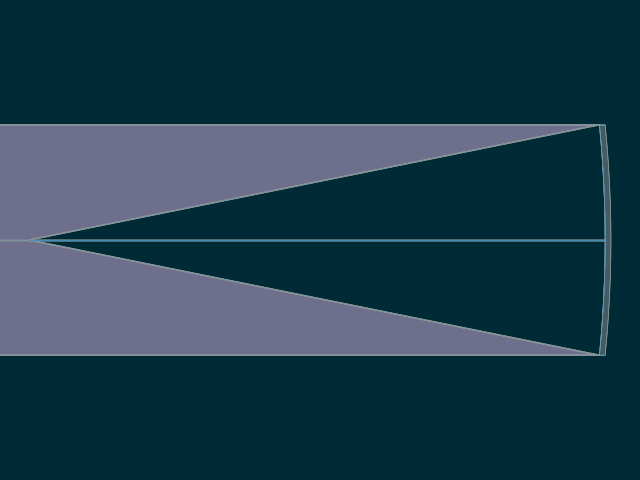

In [25]:
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm, is_dark=isdark,
                        do_draw_ray_fans=False, do_paraxial_layout=False).plot()

# List first order data

In [26]:
pm.first_order_data()

efl                 250
ffl                -250
pp1                  -0
bfl                 250
ppk                   0
f/#                 2.5
m              -2.5e-09
red              -4e+08
obj_dist          1e+11
obj_ang               1
enp_dist             -0
enp_radius           50
na obj            5e-10
n obj                 1
img_dist           -250
img_ht            4.364
exp_dist      -6.25e-07
exp_radius           50
na img           0.1961
n img                -1
optical invariant       0.8728


In [27]:
fld, wvl, foc = osp.lookup_fld_wvl_focus(0)

### create fan and grid objects for use by plot grid

In [28]:
ray_xfan = analyses.RayFan(opm, f=fld, wl=wvl, xyfan='x')
ray_yfan = analyses.RayFan(opm, f=fld, wl=wvl, xyfan='y')
ray_grid = analyses.RayGrid(opm, f=fld, wl=wvl)

In [29]:
ndim = 32
maxdim = 256
pupil_grid = analyses.RayGrid(opm, num_rays=ndim, f=fld, wl=wvl, foc=-0.0)

### Create lists of fans, data types, and plotting keyword arguments to drive 

In [30]:
xyabr_fan_list = [(ray_xfan, 'dx', dict(num_points=100)),
                  (ray_yfan, 'dy', dict(num_points=100, linestyle='--'))]

In [31]:
opd_fan_list = [(ray_yfan, 'opd', dict(linestyle='', linewidth=1, marker='D', markersize=3.5)),
                (ray_yfan, 'opd', dict(num_points=100, linewidth=2))]

### create focus dashboard

In [32]:
one_wave = opm.nm_to_sys_units(wvl)
# one wave of defocus
dfoc = one_wave/(fod.img_na**2/(2*fod.n_img))
qwrt_dfoc = abs(0.25*dfoc)

# one wave of tilt
_, _, ref_sphere_radius = fld.ref_sphere
shft = ref_sphere_radius*one_wave/fod.exp_radius

In [33]:
opd_scale = 1.0
ta_scale = .01

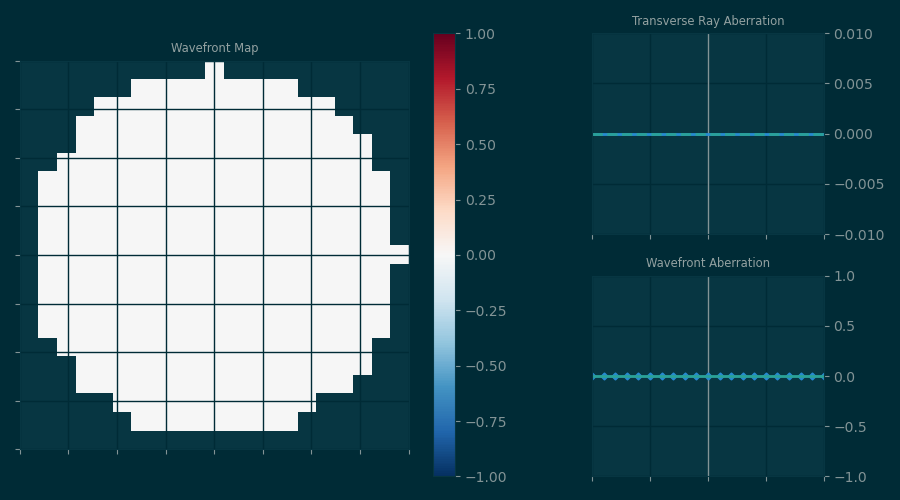

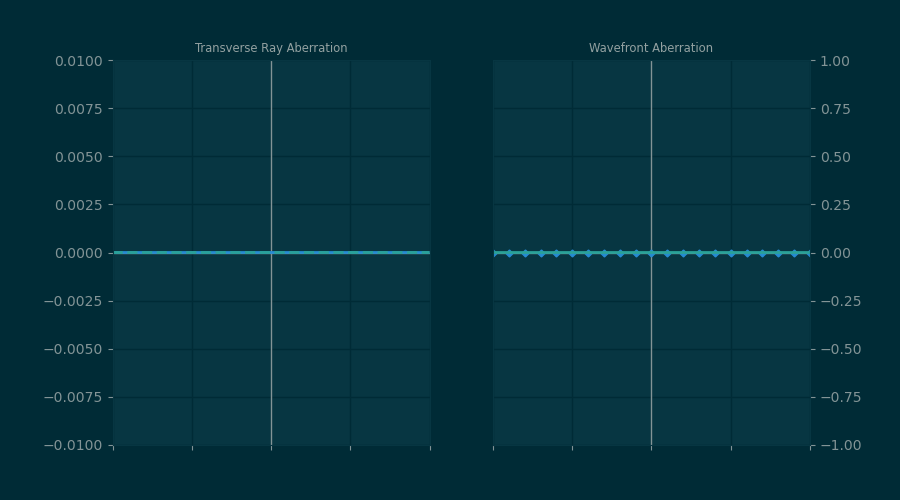

In [34]:
# create a figure with a wavefront map and transverse ray and opd ray fans
wfr = Wavefront(ray_grid, user_scale_value=opd_scale, do_contours=False, title='Wavefront Map')
xy_fan = RayFanPlot(xyabr_fan_list, user_scale_value=ta_scale, scale_type='user',
                    yaxis_ticks_position='right', title='Transverse Ray Aberration')
opd_fan = RayFanPlot(opd_fan_list, user_scale_value=opd_scale, scale_type='user',
                     yaxis_ticks_position='right', title='Wavefront Aberration')

fig = plt.figure(FigureClass=AnalysisFigure, data_objs=[ray_grid, ray_xfan, ray_yfan], subplots=[wfr, xy_fan, opd_fan],
                 grid=(8, 13), figsize=[9, 5], tight_layout=True, is_dark=isdark)
fig.gridspecs = [fig.gs[:8, :8], fig.gs[:4, 9:], fig.gs[4:8, 9:]]

fig.refresh()

# create a figure with transverse ray and opd ray fans 
tabr = RayFanPlot(xyabr_fan_list, user_scale_value=ta_scale, scale_type='user',
                title='Transverse Ray Aberration')
wabr = RayFanPlot(opd_fan_list, user_scale_value=opd_scale, scale_type='user',
                  yaxis_ticks_position='right', title='Wavefront Aberration')
fig2 = plt.figure(FigureClass=AnalysisFigure, data_objs=[ray_xfan, ray_yfan], subplots=[tabr, wabr],
                 grid=(1, 2), figsize=[9, 5], is_dark=isdark)

fig2.plot()

# create sliders for controlling defocus and image offset
defocus, x_shift, y_shift = dashboards.create_focus_dashboard([fig, fig2],
                                                   [ray_grid, ray_xfan, ray_yfan],
                                                   osp.defocus.focus_shift, abs(dfoc), shft, on_axis_pt=[0, 0])
display(widgets.HBox([defocus, y_shift]))

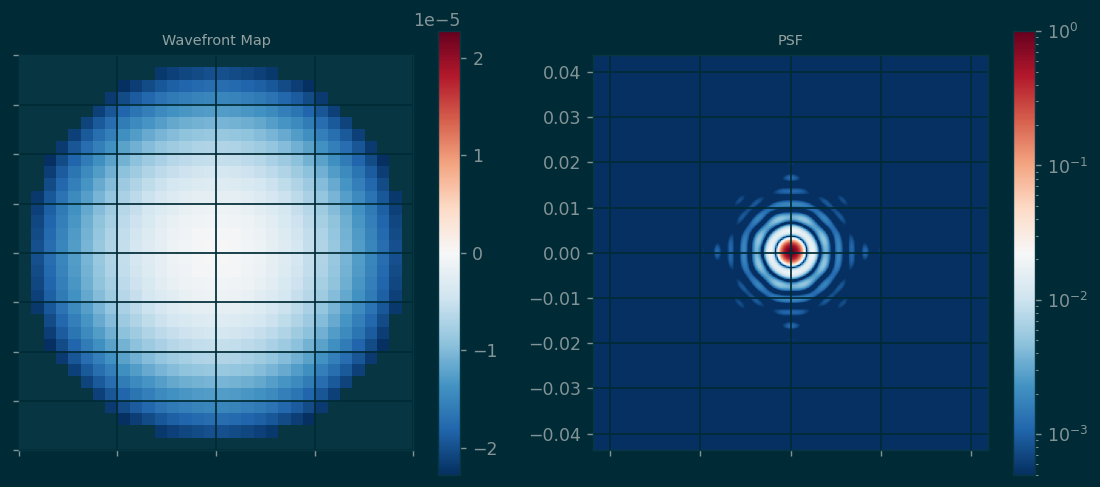

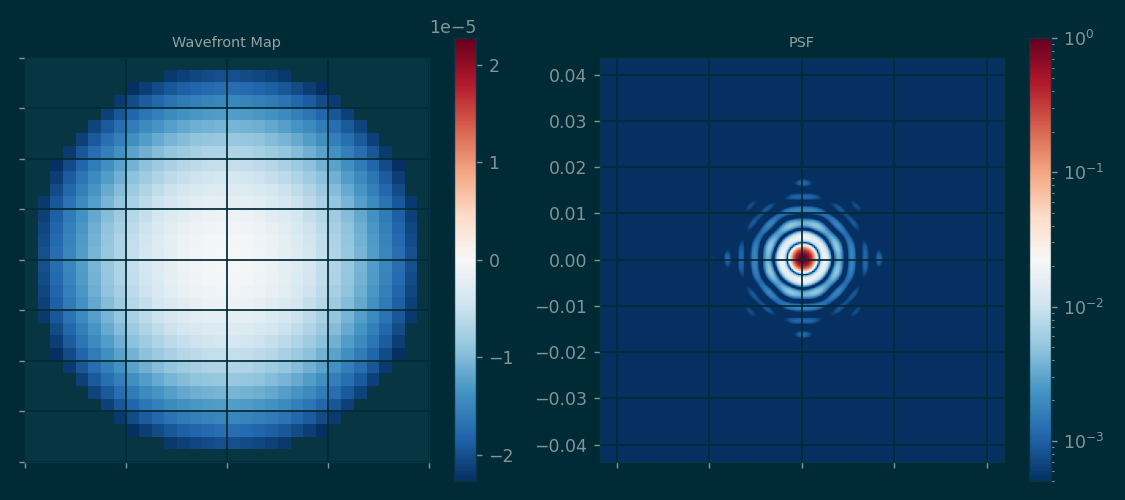

In [35]:
wfr = Wavefront(pupil_grid, user_scale_value=None, do_contours=False,
                title='Wavefront Map') #, cmap="BrBG_r")

psf = DiffractionPSF(pupil_grid, maxdim, # cmap="BrBG_r",   # cmap=cc.m_fire,
                     yaxis_ticks_position='left', title='PSF', norm=LogNorm(vmin=5e-4)) #norm=PowerNorm(gamma=0.5, vmin=2e-3))

fig_psf = plt.figure(FigureClass=AnalysisFigure, data_objs=[pupil_grid], subplots=[wfr, psf],
                     grid=(1, 2), figsize=[9, 4], dpi=125, tight_layout=True, is_dark=isdark)

fig_psf.plot()

In [36]:
from numpy.fft import fftshift, fft2

In [37]:
ndim = 64
maxdim = 4096
pupil_grid = analyses.RayGrid(opm, num_rays=ndim, f=fld, wl=wvl, foc=-0.0)

In [38]:
psf_dim = analyses.psf_sampling(maxdim, ndim)
n_airy = psf_dim[2]
psf_dim

(4096, 64, 156)

In [39]:
opd = pupil_grid.grid[2]

In [40]:
AP = analyses.calc_psf(opd, ndim, maxdim)

/var/folders/4z/p2jynsyn64qcg_j024rv_3vw0000gn/T/ipykernel_61783/2664252138.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


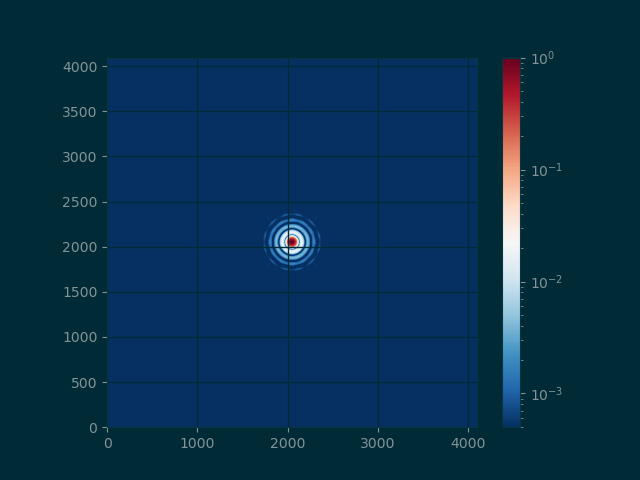

In [41]:
figg = plt.figure()
plt.imshow(AP, origin='lower', cmap="RdBu_r", norm=LogNorm(vmin=5e-4))
plt.colorbar()
plt.show()

In [42]:
delta_x, delta_xp = analyses.calc_psf_scaling(pupil_grid, ndim, maxdim)

In [43]:
maxdim_by_2 = maxdim//2
W = np.zeros([maxdim, maxdim])
nd2 = ndim//2

In [44]:
image_scale = maxdim_by_2 * delta_xp
xi = np.linspace(-image_scale, image_scale, maxdim)
yi = np.linspace(-image_scale, image_scale, maxdim)
#xi = np.linspace(-image_scale, image_scale, nd)
#yi = np.linspace(-image_scale, image_scale, nd)
[XI, YI] = np.meshgrid(xi, yi)

/var/folders/4z/p2jynsyn64qcg_j024rv_3vw0000gn/T/ipykernel_61783/1975768424.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


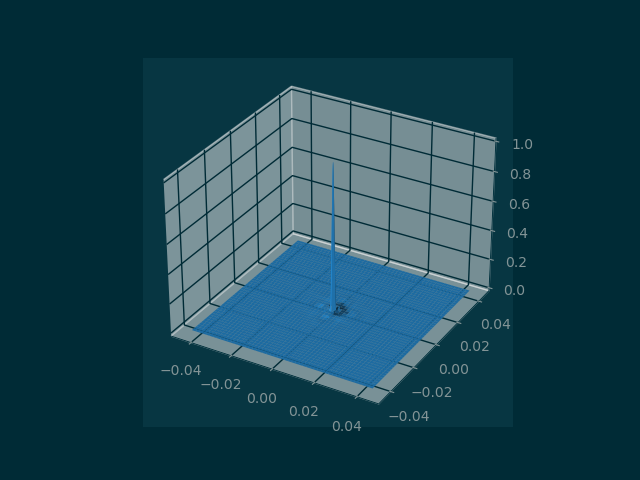

In [45]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(XI, YI, AP)

In [46]:
delta_x, delta_xp, image_scale

(1.5625, 2.133101567832754e-05, 0.0436859201092148)

In [47]:
maxdim/n_airy, maxdim/ndim

(26.256410256410255, 64.0)

In [48]:
psf_dim

(4096, 64, 156)